In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import Evaluation

In [2]:
data=pd.read_csv('ratings_Electronics.csv',names=['UserID','ProductID','Rating','Timestamp'])

In [3]:
data.head()

,UserID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
data.shape

(7824482, 4)

In [5]:
data.dtypes

UserID        object
ProductID     object
Rating       float64
Timestamp      int64
dtype: object

In [6]:
data.isna().sum()

UserID       0
ProductID    0
Rating       0
Timestamp    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000A58308D2E8>,
      dtype=object)

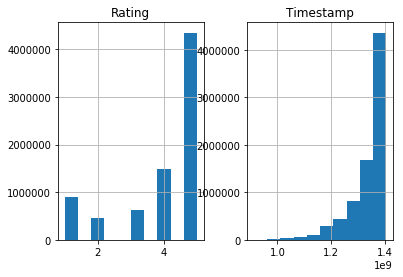

In [8]:
data.hist()

In [9]:
val_count=data['UserID'].value_counts()

In [10]:
#Select users with more than 50 ratings 
data=data[data['UserID'].isin(val_count[val_count>=50].index)]

In [11]:
data.shape

(125871, 4)

In [12]:
data['UserID'].unique().shape

(1540,)

In [13]:
data.head()

,UserID,ProductID,Rating,Timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


In [14]:
#train test split
train_data,test_data=train_test_split(data,test_size=0.3,random_state=1)

In [76]:
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {self.user_id: 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations

In [78]:
#Popularity based recommendation based on number of purchasdes
pm = popularity_recommender_py()
pm.create(train_data, 'UserID', 'ProductID')

In [80]:
users = data['UserID'].unique()
user_id = users[16]
pm.recommend(user_id)

,user_id,ProductID,score,Rank
30797,A1PPS91NLI7KEH,B0088CJT4U,155,1.0
19529,A1PPS91NLI7KEH,B003ES5ZUU,124,2.0
8601,A1PPS91NLI7KEH,B000N99BBC,122,3.0
30194,A1PPS91NLI7KEH,B007WTAJTO,112,4.0
30489,A1PPS91NLI7KEH,B00829TIEK,100,5.0
31064,A1PPS91NLI7KEH,B008DWCRQW,94,6.0
17278,A1PPS91NLI7KEH,B002R5AM7C,93,7.0
22667,A1PPS91NLI7KEH,B004CLYEDC,93,8.0
30485,A1PPS91NLI7KEH,B00829THK0,91,9.0
17459,A1PPS91NLI7KEH,B002SZEOLG,89,10.0


In [86]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 5:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no products for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique products for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique products in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique products in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

In [87]:
is_model = item_similarity_recommender_py()
is_model.create(train_data, 'UserID', 'ProductID')

In [90]:
#Comparison
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

NameError: name 'time' is not defined

In [88]:
#Top 5 Recommendations
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: A3TAS1AG6FMBQW:
------------------------------------------------------------------------------------
B00BAEVR4I
B00BD7UXXS
B00894YWD0
B00C97AF16
B00406YHLI
B000VZS2EU
B000I68BD4
B0032JPDFI
B001PI09SE
B00DOWCQL2
B001T9NUJE
B00IWQ3Y20
B00603RTC8
B008RW6RGE
B00A7PPLP2
B0001OHH0Q
B001TH7GSW
B003CIBCX6
B00A6YOUWE
B0063705PE
B002IW99AU
B001VKQR5U
B007IO38MI
B00A750SCI
B000WYVBR0
B00HNJWVO4
B00681RUR6
B00005OOJZ
B00COF7DGS
B006DY3CRK
B009RQW3BC
B001F51G16
B00486MH80
B00CROC9JC
B0061S1INS
B004J1G2MQ
B00G6CLN3Y
B00CF5OHZ2
B006ZP8UOW
B00B9KOCYA
B009NHWVIA
B00IAUJF6W
B001F7HLRC
B007BYLKFW
B00EQD5ZS4
B00CBCUS1G
B009SG71MC
B003X26PMO
B008U25LI6
B009D79VH4
B002WE6D44
B005KGOMI0
B00000K13A
B00D8X9FSY
B003ELYQGG
B004CLYEFK
B004NEULF8
B005CLPP84
B006GWO5WK
B00HWMPSF6
B001M4XCHQ
B00JEVI0US
B008S4TSAI
B003ZX8B3W
B00DQZQPNM
B00000K0JC
0972683275
B0067WUVF4
B003ICXCZM
B00BWL33H8
B00

,user_id,song,score,rank
0,A3TAS1AG6FMBQW,B008X9Z528,0.016760,1
1,A3TAS1AG6FMBQW,B0079UAT0A,0.015672,2
2,A3TAS1AG6FMBQW,B008ULPA2O,0.015185,3
3,A3TAS1AG6FMBQW,B008X9ZBVI,0.015164,4
4,A3TAS1AG6FMBQW,B008ULPE70,0.014969,5


#Insights
Popularity based model recommends products based on the other users purchase data. It does not give personalized recommendations. It gives same recommendation for all users based on popularity of product.

Collaborative filtering gives personalized recommendations based on user behaviour. It considers the ratings given by user to products and ratings given by users with similar behaviour. Every user has different recommendations.